# Solución al problema del costo de un seguro

Primeramente se realizará un preprocesamiento de la información, es decir, se realizará una lectura del archivo .csv y lso datos se guardarán en forma de un arreglo para su posterior uso.

In [93]:
#Importación de librerías que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing as pp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Adquisición de datos del dataset
path = "dataset/"
file = "insurance.csv"
insurance_file = pd.read_csv(path + file)
print(insurance_file)
insurance_file.columns

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

De la lectura e impresión de los datos del archivo *csv* es posible notar que cuenta con 7 columnas: 
- Age
- Sex
- bmi
- Children
- Smoker
- Region
- Charges

Los datos que se usarán crudos son las columnas 'Age', 'bmi', 'Children' y 'Charges', mientras que las columnas 'Sex', 'Smoker' y 'Region' serán preprocesados.

In [94]:
#Preprocesamiento de datos
insurance_file["sex"] = [(1.0, 2.0)["female"==s] for s in insurance_file["sex"]]
insurance_file["smoker"] = [(1.0, 2.0)["yes"==s] for s in insurance_file["smoker"]]
insurance_file["region"] = [(s, 1.0)["northeast"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 2.0)["northwest"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 3.0)["southeast"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 4.0)["southwest"==s] for s in insurance_file["region"]]

print(insurance_file["region"])

0       4.0
1       3.0
2       3.0
3       2.0
4       2.0
       ... 
1333    2.0
1334    1.0
1335    3.0
1336    4.0
1337    2.0
Name: region, Length: 1338, dtype: float64


Seguidamente mostraremos algunas gráficas entre las variables del problema y el mapa de calor mediante la librería *Seaborn*

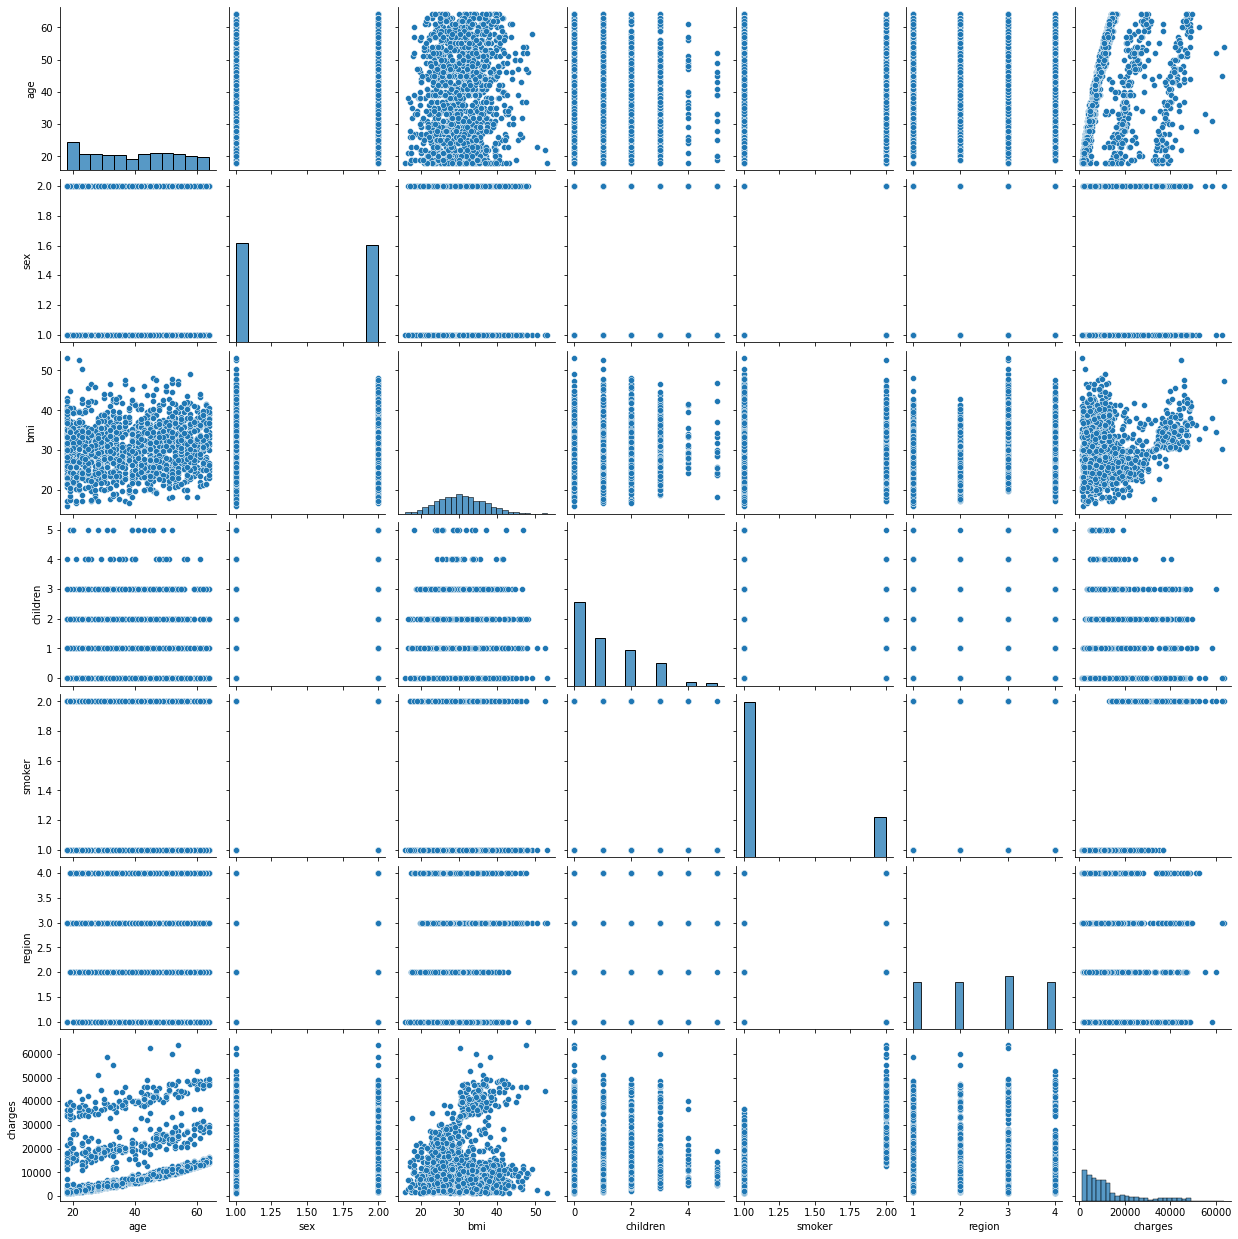

In [95]:
sns.pairplot(insurance_file)
plt.show()

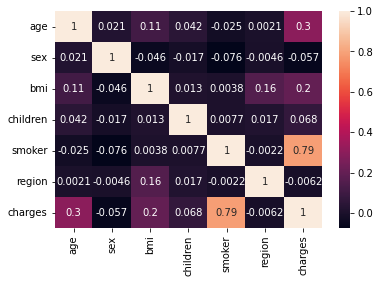

In [96]:
sns.heatmap(insurance_file.corr(), annot=True)
plt.show()

Para acabar con la parte de adquisición y preprocesamiento de datos armaremos los vectores que se usarán en los modelos

In [104]:
#Seleccionamos los conjuntos de datos
x = np.array(insurance_file[['age', 'sex', 'bmi', 'children', 'smoker', 'region']], dtype=float) #verificar smoker, sex y region
y = np.array(insurance_file[['charges']], dtype=float)

#Dividimos los datos en conjuntos de entrenamiento y prueba
seed = 97
test = 0.20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test, random_state=seed)

## Ecuación Normal

In [105]:
#Entrenando
w = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

print(f"Las dimensiones de x son: {np.shape(x_train)}")
print(f"Los pesos hallados son: {w}")

Las dimensiones de x son: (1070, 6)
Los pesos hallados son: [[  166.5879039 ]
 [-4215.73310794]
 [ -180.90424787]
 [ -222.23725778]
 [18420.67213969]
 [-1093.61790383]]


[]

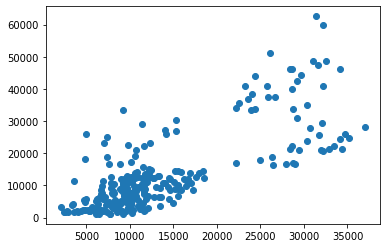

In [107]:
y_pred = x_test @ w
plt.scatter(y_pred, y_test)
plt.plot()

## Batch Gradient Descent

El algoritmo del gradient descent sigue la siguiente ecuación:

$$\theta_j = \theta_j - \eta \nabla_{\theta}J(\theta, x, y)$$

In [122]:
lr = 0.001
epochs = 20000

theta = np.random.rand(6, 1) #REalizamos una inicialización inicial aleatoria
j = np.zeros(epochs) 
m = np.size(x_train)

#Escalamiento de datos
scaler01 = pp.MinMaxScaler() #Normalizacipón
scaler02 = pp.StandardScaler() #Estandarización

x_train_scaled = scaler02.fit_transform(x_train)
y_train_scaled = scaler02.fit_transform(y_train)

for i in range(epochs):
    j[i] = (2/m) * ((x_train_scaled@theta - y_train_scaled)**2).sum()   
    grad = 1/m * x_train_scaled.T.dot(x_train_scaled.dot(theta) - y_train_scaled)
    theta = theta - lr * grad
    

print(f"Los pesos hallados son: {theta}")

Los pesos hallados son: [[ 0.3003589 ]
 [ 0.04583725]
 [ 0.16787645]
 [ 0.04673074]
 [ 0.80271342]
 [-0.0225071 ]]


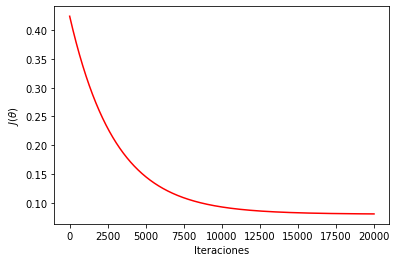

In [123]:
plt.plot(np.arange(epochs), j, 'r')
plt.xlabel('Iteraciones')
plt.ylabel(r'$J(\theta)$')
plt.show()

[]

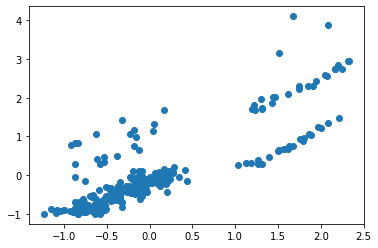

In [124]:
x_test_scaled = scaler02.fit_transform(x_test)
y_test_scaled = scaler02.fit_transform(y_test)

y2_pred = x_test_scaled @ theta
plt.scatter(y2_pred, y_test_scaled)
plt.plot()

## Mini batch gradient descent

**NOTA: VERIFICAR SI LOS RESULTADOS ESTÁN BIEN Y CAMBIAR LA FUNCIÓN DE CREATE_MINI_BATCHES**

In [168]:
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

epochs_mini = 10
lr_mini = 0.001
batch_size = 25

theta_mini = np.random.randn(6, 1)
j_mini = []

for e in range(epochs_mini):
    
    mini_batches = create_mini_batches(x_train_scaled, y_train_scaled, batch_size)
    
    for mini in mini_batches:
        x_mini, y_mini = mini
        grad_mini = 2*x_mini.T.dot(x_mini.dot(theta_mini)-y_mini)
        theta_mini = theta_mini - lr_mini * grad_mini
        j_mini.append((2/m) * ((x_test_scaled@theta_mini - y_test_scaled)**2).sum())
        

print(theta_mini)


[[ 0.30282068]
 [ 0.01586967]
 [ 0.16611216]
 [ 0.02730012]
 [ 0.79297421]
 [-0.02759891]]


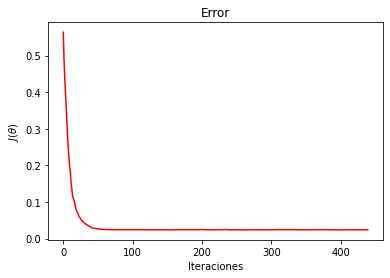

In [169]:
plt.plot(j_mini, 'r')
plt.xlabel('Iteraciones')
plt.ylabel(r'$J(\theta)$')
plt.title('Error')
plt.show()

## Stochastic gradient descent

In [147]:
epochs_st = 100
t0, t1 = 5, 50
batch_size = 1

def learning_schedule(t):
    return t0 / (t+t1)

theta_st = np.random.randn(6, 1)
j_st = np.zeros(epochs_st)

for e in range(epochs_st):
    j_st[e] = (2/m) * ((x_test_scaled@theta_st - y_test_scaled)**2).sum()   
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_test_scaled[random_index:random_index+batch_size]
        yi = y_test_scaled[random_index:random_index+batch_size]
        grad_st = 2*xi.T.dot(xi.dot(theta)-yi)
        lr_st = learning_schedule(e* m+i)
        theta_st = theta_st - lr_st*grad_st

print(theta_st)


[[-0.5741178 ]
 [ 1.31825445]
 [-0.59282357]
 [ 0.60430371]
 [ 0.45984601]
 [-0.46772881]]


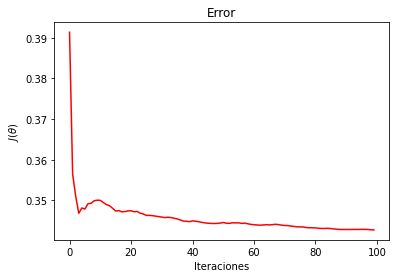

In [148]:
plt.plot(np.arange(epochs_st), j_st, 'r')
plt.xlabel('Iteraciones')
plt.ylabel(r'$J(\theta)$')
plt.title('Error')
plt.show()